<a href="https://colab.research.google.com/github/showerju/ArtifictionIntelligence/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#DenseNet_121 작성
#pakage

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch import optim

import os
import copy
import time

import numpy as np

import pathlib

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

import gc
gc.collect()
torch.cuda.empty_cache()

Using cuda device


In [32]:
mean = [0.491, 0.482 ,0.421]
std = [0.347, 0.243 ,0.461]

In [33]:
#학습 이미지 다운로드 & 전처리

transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std),
                                      ])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std),
                                     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.421], std=[0.347, 0.243, 0.461])
           )

In [28]:
print(trainset[0][0].shape)

torch.Size([3, 224, 224])


In [35]:
print(trainset[0][0])

tensor([[[-0.7482, -0.7482, -0.7482,  ...,  0.2576,  0.2576,  0.2576],
         [-0.7482, -0.7482, -0.7482,  ...,  0.2576,  0.2576,  0.2576],
         [-0.7482, -0.7482, -0.7482,  ...,  0.2576,  0.2576,  0.2576],
         ...,
         [ 0.5854,  0.5854,  0.5854,  ..., -0.0249, -0.0249, -0.0249],
         [ 0.5854,  0.5854,  0.5854,  ..., -0.0249, -0.0249, -0.0249],
         [ 0.5854,  0.5854,  0.5854,  ..., -0.0249, -0.0249, -0.0249]],

        [[-0.9830, -0.9830, -0.9830,  ...,  0.0176,  0.0176,  0.0176],
         [-0.9830, -0.9830, -0.9830,  ...,  0.0176,  0.0176,  0.0176],
         [-0.9830, -0.9830, -0.9830,  ...,  0.0176,  0.0176,  0.0176],
         ...,
         [ 0.3404,  0.3404,  0.3404,  ..., -0.4988, -0.4988, -0.4988],
         [ 0.3404,  0.3404,  0.3404,  ..., -0.4988, -0.4988, -0.4988],
         [ 0.3404,  0.3404,  0.3404,  ..., -0.4988, -0.4988, -0.4988]],

        [[-0.3773, -0.3773, -0.3773,  ..., -0.0370, -0.0370, -0.0370],
         [-0.3773, -0.3773, -0.3773,  ..., -0

In [36]:
np.mean(trainset[0][0].numpy(),axis=(1,2))

array([ 0.18082255, -0.2874266 , -0.36849037], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


 출력 index :  [4058, 29911, 18607, 42137, 31851, 26834, 26776, 29721, 15342, 15126] / 총 10 개 이미지 



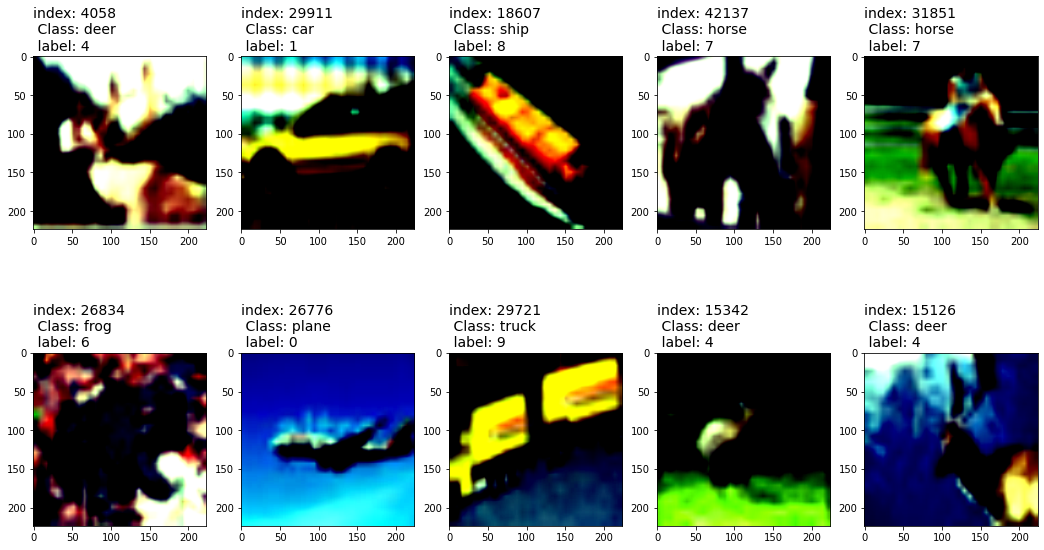

In [37]:
import random
import matplotlib.pyplot as plt
%matplotlib inline 

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#이미지 배열로 살펴보기

range_List = []

#리스트에 random index 저장
for i in range(10):
    ran = random.randint(0,49999)
    range_List.append(ran)



#figure size / 배열 설정
rows = 2
columns = 5
img_index = 0
plt.rcParams['figure.figsize'] = (18.0, 10.0)


title_font = {
    'fontsize': 14,
}

#figure안에 이미지 넣기
for i in range_List :
    img_index += 1
    img, label = trainset[i]
    header = 'index: {} \n Class: {} \n label: {}'.format(i,class_names[label],label)
    
    npimg = img.numpy()
    plt.subplot(rows, columns, img_index)
    plt.title(header,fontdict=title_font,loc='left')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
print('\n 출력 index : ',range_List,'/ 총',len(range_List),'개 이미지 \n')
plt.show()

In [8]:
# DenseNet BottleNeck
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)


# Transition Block: reduce feature map size and number of channels
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

In [9]:
# DenseNet
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121():
    return DenseNet([6, 12, 24, 16])

In [10]:
# check model
x = torch.randn(3, 3, 224, 224)
model = DenseNet_121()
output = model(x)
print(output.size())

torch.Size([3, 10])


In [11]:
# print model summary
from torchsummary import summary
model.to("cuda:0")
summary(model, (3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]           3,552
         MaxPool2d-2           [-1, 24, 56, 56]               0
       BatchNorm2d-3           [-1, 24, 56, 56]              48
              ReLU-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 48, 56, 56]           1,152
       BatchNorm2d-6           [-1, 48, 56, 56]              96
              ReLU-7           [-1, 48, 56, 56]               0
            Conv2d-8           [-1, 12, 56, 56]           5,184
        BottleNeck-9           [-1, 36, 56, 56]               0
      BatchNorm2d-10           [-1, 36, 56, 56]              72
             ReLU-11           [-1, 36, 56, 56]               0
           Conv2d-12           [-1, 48, 56, 56]           1,728
      BatchNorm2d-13           [-1, 48, 56, 56]              96
             ReLU-14           [-1, 48,

In [12]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.08)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)


# learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# 미니배치
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# 미니배치 loss
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# 학습 파라미터 받기
def train_test(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    test_dl=params['test_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'test': []}
    metric_history = {'train': [], 'test': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, test_dl, sanity_check)
        loss_history['test'].append(test_loss)
        metric_history['test'].append(test_metric)

        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(test_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, test loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, test_loss, 100*test_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [15]:
# 파라미터 세팅
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'test_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}


def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [16]:
model, loss_hist, metric_hist = train_test(model, params_train)

Epoch 1/10, current lr= 0.08
Copied best model weights!
train loss: 1.338965, test loss: 1.359510, accuracy: 49.01, time: 8.2257 min
----------
Epoch 2/10, current lr= 0.08
Copied best model weights!
train loss: 1.155280, test loss: 1.193679, accuracy: 57.58, time: 16.4318 min
----------
Epoch 3/10, current lr= 0.08
Copied best model weights!
train loss: 1.040797, test loss: 1.053815, accuracy: 63.15, time: 24.6666 min
----------
Epoch 4/10, current lr= 0.08
Copied best model weights!
train loss: 0.954628, test loss: 0.942988, accuracy: 66.00, time: 32.8931 min
----------
Epoch 5/10, current lr= 0.08
Copied best model weights!
train loss: 0.893188, test loss: 0.891013, accuracy: 67.85, time: 41.1202 min
----------
Epoch 6/10, current lr= 0.08
Copied best model weights!
train loss: 0.828095, test loss: 0.840323, accuracy: 70.43, time: 49.3507 min
----------
Epoch 7/10, current lr= 0.08
Copied best model weights!
train loss: 0.772067, test loss: 0.806733, accuracy: 71.58, time: 57.5551 m

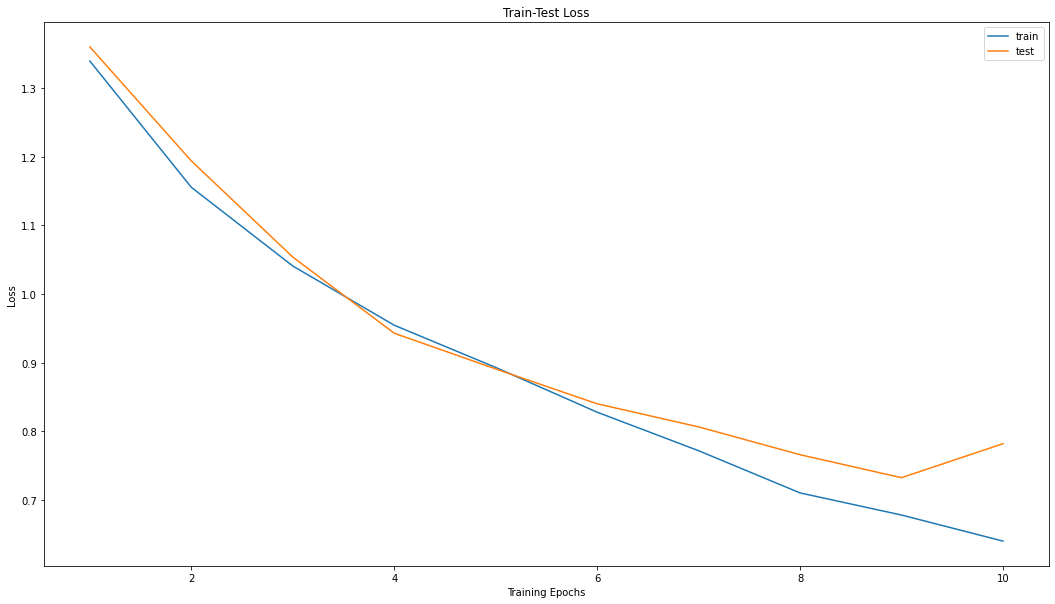

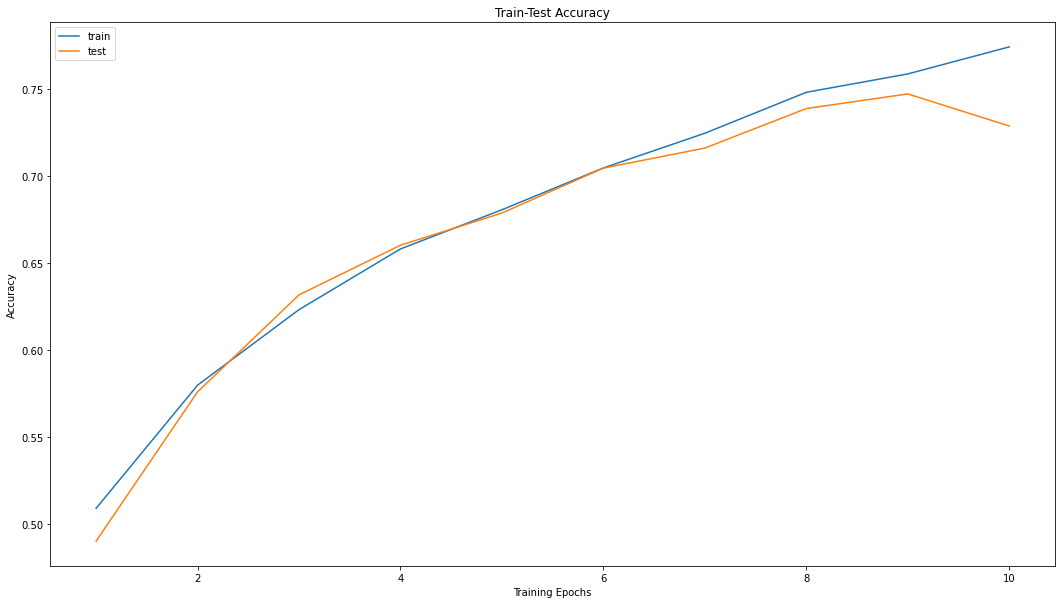

In [17]:
# Train-Test progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Test Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['test'], label='test')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Test Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['test'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()